In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns


from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam

from pathlib import Path
import os.path


from sklearn.metrics import classification_report, confusion_matrix


e:\minicondareal\envs\tensormain\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:

import sys

import pandas as pd

import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print()
print(f"Python {sys.version}")
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensor Flow Version: 2.10.0

Python 3.9.18 (main, Sep 11 2023, 14:09:26) [MSC v.1916 64 bit (AMD64)]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


In [3]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)

    # Seed value for NumPy
    np.random.seed(seed)

    # Seed value for Python's random library
    random.seed(seed)

    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-02-20 12:58:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py'

     0K ..........                                            100% 7.68M=0.001s

2024-02-20 12:58:20 (7.68 MB/s) - 'helper_functions.py' saved [10246/10246]



In [5]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [6]:
# Walk through each directory
dataset = r'E:\ClothesA'
walk_through_dir(dataset)

There are 9 directories and 0 images in 'E:\ClothesA'.
There are 0 directories and 240 images in 'E:\ClothesA\Full Pant'.
There are 0 directories and 240 images in 'E:\ClothesA\Full Sleeve Shirt'.
There are 0 directories and 240 images in 'E:\ClothesA\Full Sleeve T-Shirt'.
There are 0 directories and 240 images in 'E:\ClothesA\Half Pant'.
There are 0 directories and 240 images in 'E:\ClothesA\Half Sleeve Shirt'.
There are 0 directories and 240 images in 'E:\ClothesA\Half Sleeve T-Shirt'.
There are 0 directories and 240 images in 'E:\ClothesA\Hoodie'.
There are 0 directories and 240 images in 'E:\ClothesA\Jacket'.
There are 0 directories and 240 images in 'E:\ClothesA\Sweater'.


In [7]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths =   list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.jpeg'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

In [8]:
label_counts = image_df['Label'].value_counts()
print(label_counts)

Label
Full Pant              240
Full Sleeve Shirt      240
Full Sleeve T-Shirt    240
Half Pant              240
Half Sleeve Shirt      240
Half Sleeve T-Shirt    240
Hoodie                 240
Jacket                 240
Sweater                240
Name: count, dtype: int64


C:\Users\mehra\AppData\Local\Temp\ipykernel_11872\2361829875.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
C:\Users\mehra\AppData\Local\Temp\ipykernel_11872\2361829875.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(label_counts.index, rotation=45)


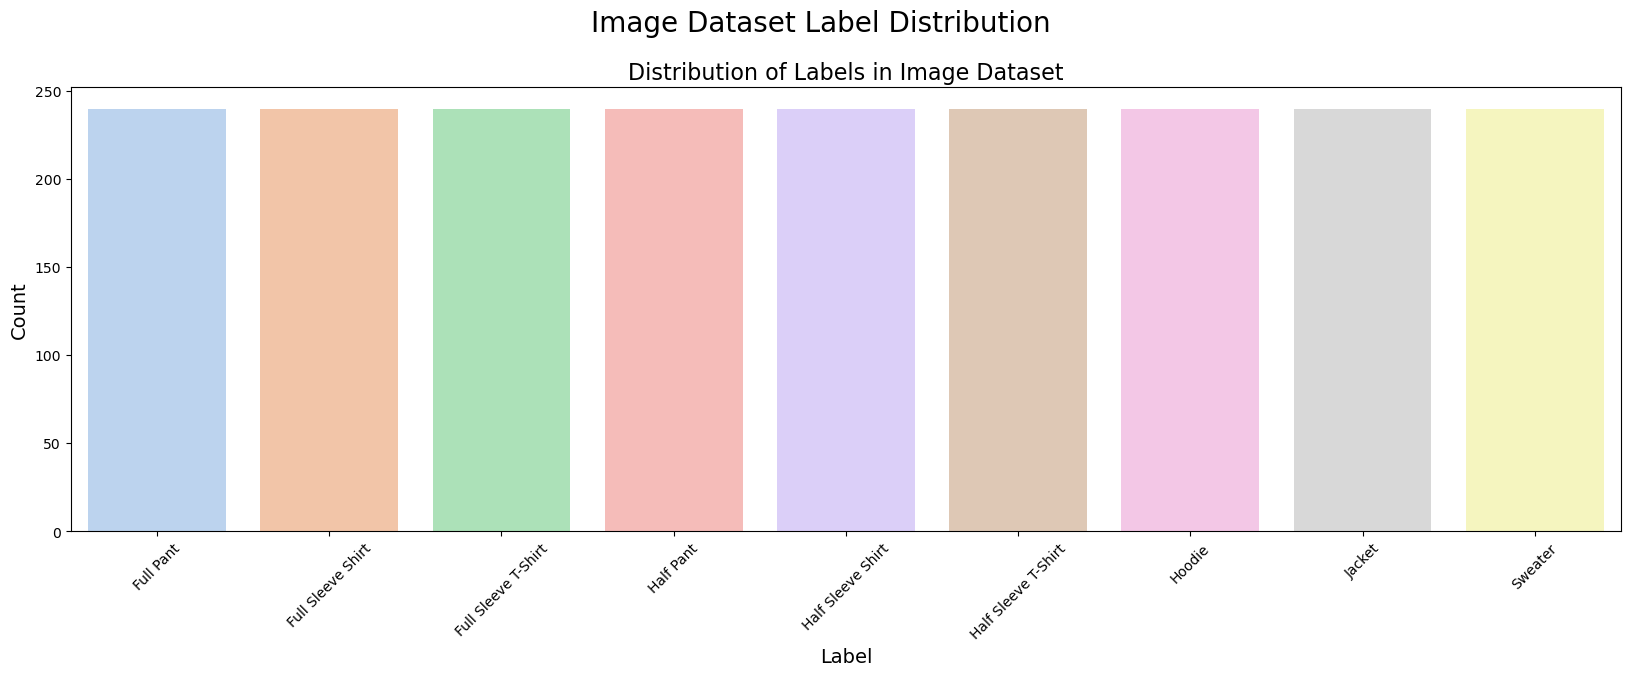

In [9]:
# Get the value counts for each label
label_counts = image_df['Label'].value_counts()

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

# Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels in Image Dataset', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)
axes.set_xticklabels(label_counts.index, rotation=45)

# Add a super-title to the figure
fig.suptitle('Image Dataset Label Distribution', fontsize=20)

# Adjust the spacing between the plots and the title
fig.subplots_adjust(top=0.85)

# Display the plot
plt.show()

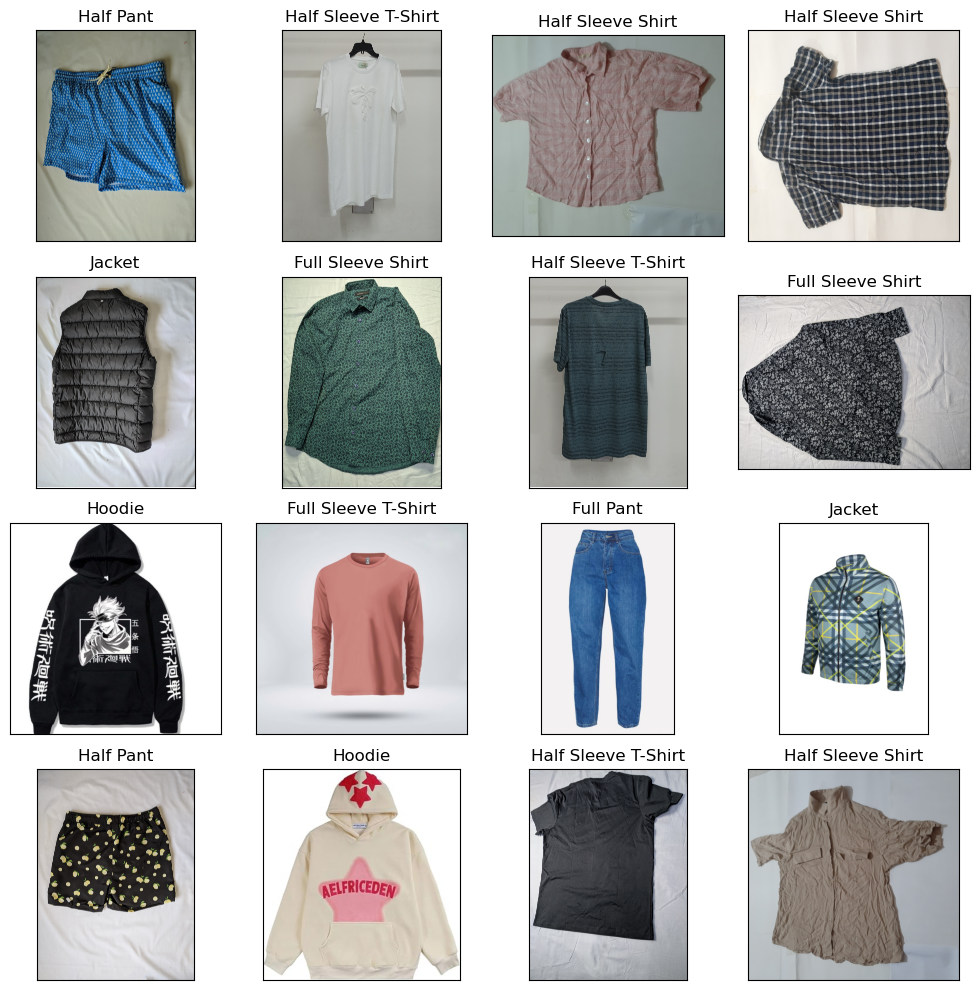

In [10]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [11]:
image_df

Filepath      Label
0       E:\ClothesA\Full Pant\Full Pant (1).jpg  Full Pant
1      E:\ClothesA\Full Pant\Full Pant (10).jpg  Full Pant
2     E:\ClothesA\Full Pant\Full Pant (100).jpg  Full Pant
3     E:\ClothesA\Full Pant\Full Pant (101).jpg  Full Pant
4     E:\ClothesA\Full Pant\Full Pant (102).jpg  Full Pant
...                                         ...        ...
2155         E:\ClothesA\Hoodie\Hoodie (9).jpeg     Hoodie
2156         E:\ClothesA\Jacket\Jacket (1).jpeg     Jacket
2157       E:\ClothesA\Jacket\Jacket (238).jpeg     Jacket
2158       E:\ClothesA\Jacket\Jacket (239).jpeg     Jacket
2159         E:\ClothesA\Jacket\Jacket (4).jpeg     Jacket

[2160 rows x 2 columns]

In [12]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.1, shuffle=True, random_state=42)

In [13]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input,
)

In [14]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 1556 validated image filenames belonging to 9 classes.
Found 388 validated image filenames belonging to 9 classes.
Found 216 validated image filenames belonging to 9 classes.


In [15]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomContrast(factor=0.2),  # Adjust contrast
  layers.experimental.preprocessing.RandomFlip(mode="horizontal"),  # Horizontal flipping
  layers.experimental.preprocessing.RandomRotation(factor=0.2),  # Adjust rotation
  layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Random translation
  layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),  # Random zoom
  layers.experimental.preprocessing.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),  # Random zoom with a wider range
  layers.experimental.preprocessing.RandomContrast(factor=0.1),  # Further adjust contrast
  layers.experimental.preprocessing.RandomRotation(factor=0.1),  # Further adjust rotation
  layers.experimental.preprocessing.RandomTranslation(height_factor=0.05, width_factor=0.05),  # Further adjust translation
  layers.experimental.preprocessing.RandomZoom(height_factor=0.1, width_factor=0.1),  # Further adjust zoom
])

In [16]:
# Load the pretained model
pretrained_model = tf.keras.applications.DenseNet201(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [17]:
pretrained_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [18]:
pretrained_model.trainable = True
set_trainable = False

for layer in pretrained_model.layers:
    if layer.name == 'conv5_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
for layer in pretrained_model.layers:
    print(layer.name,layer.trainable)

input_1 False
zero_padding2d False
conv1/conv False
conv1/bn False
conv1/relu False
zero_padding2d_1 False
pool1 False
conv2_block1_0_bn False
conv2_block1_0_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_concat False
conv2_block2_0_bn False
conv2_block2_0_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_concat False
conv2_block3_0_bn False
conv2_block3_0_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_concat False
conv2_block4_0_bn False
conv2_block4_0_relu False
conv2_block4_1_conv False
conv2_block4_1_bn False
conv2_block4_1_relu False
conv2_block4_2_conv False
conv2_block4_concat False
conv2_block5_0_bn False
conv2_block5_0_relu False
conv2_block5_1_conv False
conv2_block5_1_bn False
conv2_block5_1_relu False
conv2_block5_2_conv False
conv2_block5_conc

In [19]:
# Create checkpoint callback
checkpoint_path = "clothes_densenet_model_checkpoint1"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 6,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6)

In [20]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)


outputs = Dense(9, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [22]:
from tensorflow.keras.callbacks import Callback

class StopTrainingCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 0.987:
            print("\nReached 98.7% training accuracy. Stopping training.")
            self.model.stop_training = True

try:
    history = model.fit(
        train_images,
        steps_per_epoch=len(train_images),
        validation_data=val_images,
        validation_steps=len(val_images),
        epochs=100,
        callbacks=[
            early_stopping,
            create_tensorboard_callback("training_logs", "clothes_classification_densenet201_1"),
            checkpoint_callback,
            reduce_lr,
            StopTrainingCallback()  # Add the custom callback to stop training
        ]
    )
except KeyboardInterrupt:
    # Training interrupted by keyboard interrupt
    # Access the training history from the `history` object
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

Saving TensorBoard log files to: training_logs/clothes_classification_densenet201_1/20240220-131338
Epoch 1/100
49/49 [==============================] - 211s 4s/step - loss: 3.3712 - accuracy: 0.1195 - val_loss: 2.5812 - val_accuracy: 0.1237 - lr: 1.0000e-05
Epoch 2/100
49/49 [==============================] - 103s 2s/step - loss: 3.0424 - accuracy: 0.1459 - val_loss: 2.1718 - val_accuracy: 0.2165 - lr: 1.0000e-05
Epoch 3/100
49/49 [==============================] - 105s 2s/step - loss: 2.7882 - accuracy: 0.1928 - val_loss: 1.8765 - val_accuracy: 0.3067 - lr: 1.0000e-05
Epoch 4/100
49/49 [==============================] - 104s 2s/step - loss: 2.4776 - accuracy: 0.2449 - val_loss: 1.6519 - val_accuracy: 0.4381 - lr: 1.0000e-05
Epoch 5/100
49/49 [==============================] - 105s 2s/step - loss: 2.3036 - accuracy: 0.2853 - val_loss: 1.4799 - val_accuracy: 0.5335 - lr: 1.0000e-05
Epoch 6/100
49/49 [==============================] - 103s 2s/step - loss: 2.1941 - accuracy: 0.3310 - val

In [23]:
model.save("clothes_denseNet_mainrun.h5")

In [24]:
training_history = history.history

In [25]:
with open('metrics_MAIN.txt', 'w') as file:
    file.write("Training Accuracy: {}\n".format(training_history['accuracy']))
    file.write("Validation Accuracy: {}\n".format(training_history['val_accuracy']))
    file.write("Training Loss: {}\n".format(training_history['loss']))
    file.write("Validation Loss: {}\n".format(training_history['val_loss']))

In [26]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.16742
Test Accuracy: 95.83%


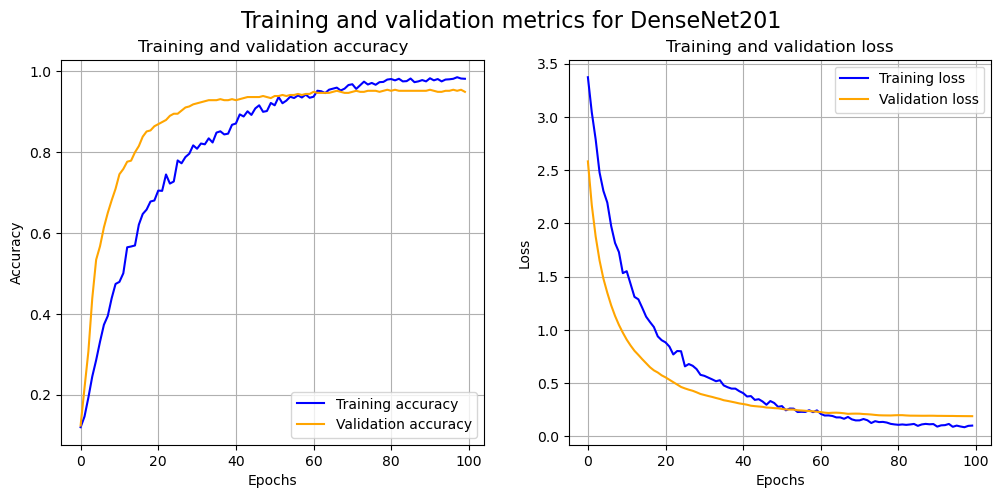

In [28]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Training Accuracy and Validation Accuracy
ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'orange', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot Training Loss and Validation Loss
ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'orange', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Overall title for the entire figure
fig.suptitle('Training and validation metrics for DenseNet201', fontsize=16)
plt.show()

In [29]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

7/7 [==============================] - 14s 2s/step
The first 5 predictions: ['Half Sleeve Shirt', 'Full Sleeve T-Shirt', 'Half Sleeve Shirt', 'Half Sleeve Shirt', 'Half Pant']


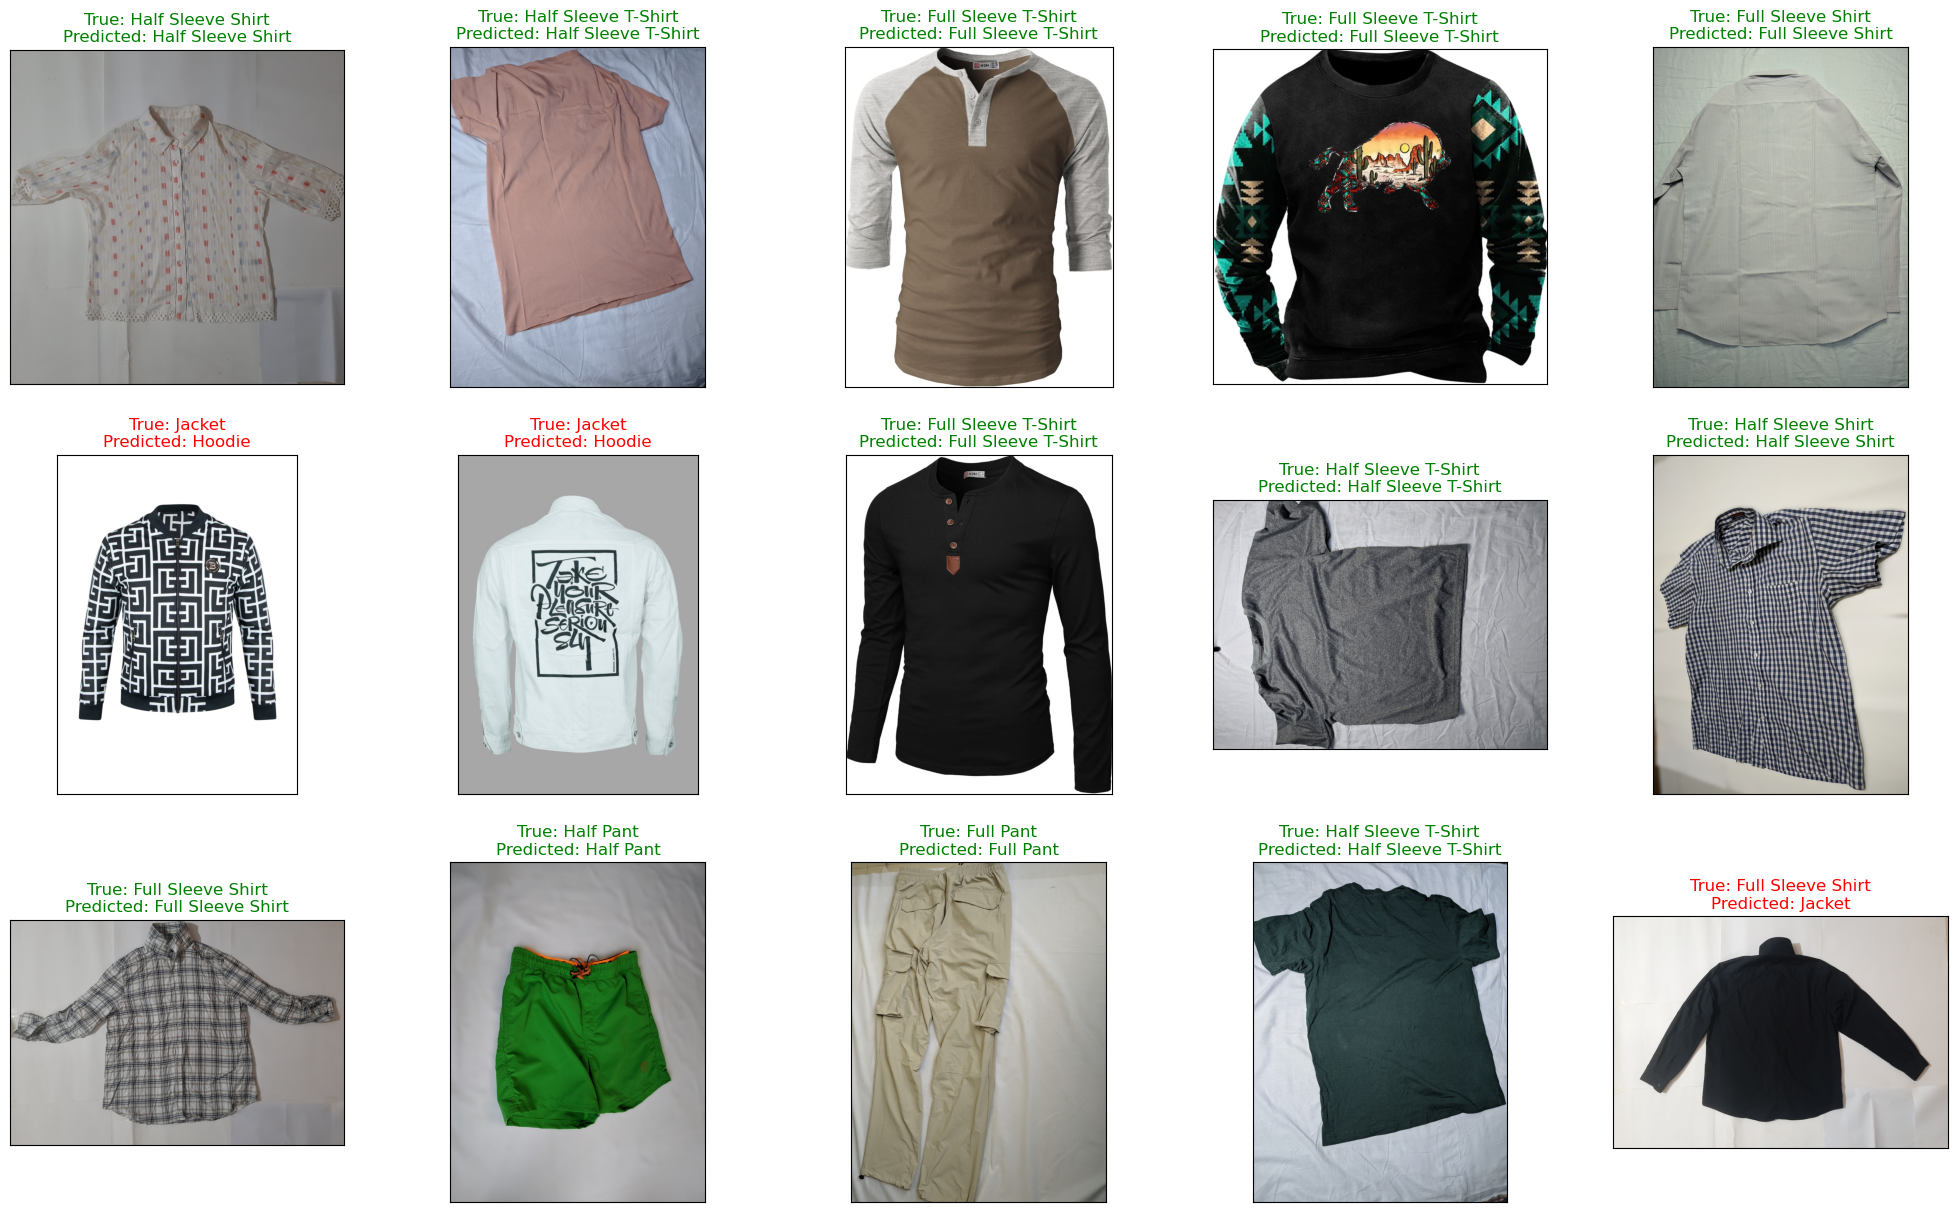

<Figure size 640x480 with 0 Axes>

In [38]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [39]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                     precision    recall  f1-score   support

          Full Pant       1.00      1.00      1.00        22
  Full Sleeve Shirt       0.96      0.89      0.93        28
Full Sleeve T-Shirt       0.96      1.00      0.98        24
          Half Pant       1.00      1.00      1.00        14
  Half Sleeve Shirt       1.00      0.96      0.98        27
Half Sleeve T-Shirt       0.95      1.00      0.98        20
             Hoodie       0.86      0.96      0.91        25
             Jacket       0.92      0.85      0.88        27
            Sweater       1.00      1.00      1.00        29

           accuracy                           0.96       216
          macro avg       0.96      0.96      0.96       216
       weighted avg       0.96      0.96      0.96       216



In [32]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score     support
Full Pant             1.000000  1.000000  1.000000   22.000000
Full Sleeve Shirt     0.961538  0.892857  0.925926   28.000000
Full Sleeve T-Shirt   0.960000  1.000000  0.979592   24.000000
Half Pant             1.000000  1.000000  1.000000   14.000000
Half Sleeve Shirt     1.000000  0.962963  0.981132   27.000000
Half Sleeve T-Shirt   0.952381  1.000000  0.975610   20.000000
Hoodie                0.857143  0.960000  0.905660   25.000000
Jacket                0.920000  0.851852  0.884615   27.000000
Sweater               1.000000  1.000000  1.000000   29.000000
accuracy              0.958333  0.958333  0.958333    0.958333
macro avg             0.961229  0.963075  0.961393  216.000000
weighted avg          0.959626  0.958333  0.958171  216.000000

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 15), text_size=10, norm=False, savefig=True):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels."""
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
    sorted_labels = sorted(labels)
    # Label the axes
    ax.set(title="Confusion Matrix of DenseNet201",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),  # create enough axis slots for each class
       yticks=np.arange(n_classes),
       xticklabels=sorted_labels,  # use the sorted labels
       yticklabels=sorted_labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

 

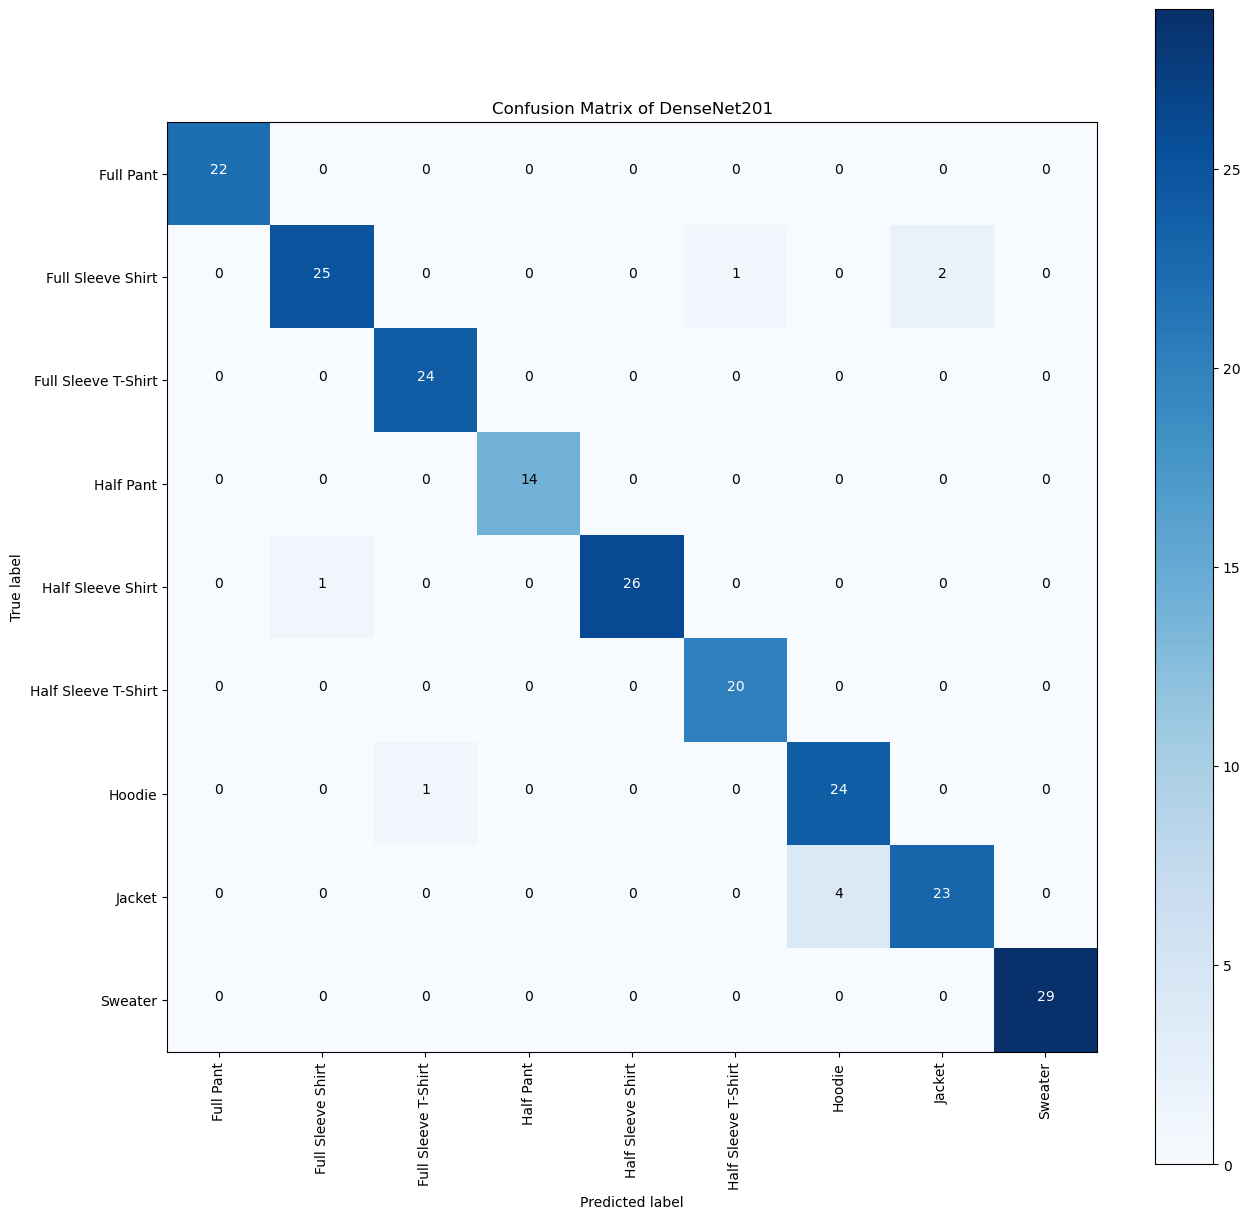

In [37]:
make_confusion_matrix(y_test, pred, list(labels.values()))